In [1]:
from lmfit import *
from iqtools import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

In [3]:
def read_and_cut_in_frecuency(filename, lframes, time, skip, xcen, xspan):
    #get iq object
    iq = get_iq_object(filename)
    iq.read_samples(1)
    #select range to read
    nframes = int(time * iq.fs / lframes)
    sframes = int(skip * iq.fs / lframes)
    #read
    iq.read(nframes = nframes, lframes = lframes, sframes = sframes)
    iq.method = 'mtm' #'fft', 'mtm', 'welch'
    #create spectrogram
    xx, yy, zz = iq.get_spectrogram(nframes, lframes) #f=x[t,p], t=y[p,f], p=z[t,f]
    #cut spectrogram in frecuency
    nxx, nyy, nzz = get_cut_spectrogram(xx, yy, zz, xcen = xcen, xspan = xspan)
    #return array with cutted spectrogram
    return nxx, nyy, nzz

def read_and_get_spectrogram(filename, lframes, time, skip):
    #get iq object
    iq = get_iq_object(filename)
    #iq.read_samples(1)
    #select range to read
    nframes = int(time * iq.fs / lframes)
    sframes = int(skip * iq.fs / lframes)
    #read
    iq.read(nframes = nframes, lframes = lframes, sframes = sframes)
    iq.method = 'mtm' #'fft', 'mtm', 'welch'
    #create spectrogram
    xx, yy, zz = iq.get_spectrogram(nframes, lframes) #f=x[t,p], t=y[p,f], p=z[t,f]
    return xx, yy, zz

def get_tiq_time(filename):
    #get iq object
    iq = get_iq_object(filename)
    return iq.date_time

def read_and_get_averaged_spectrogram(filename, lframes, time, skip):
    xx, yy, zz = read_and_get_spectrogram(filename, lframes, time, skip)
    axx, _ , azz = get_averaged_spectrogram(xx, yy, zz, len(xx[:,0]))
    return axx, azz

def get_window_averaged(filename, lframes, time, skip, xcen, xspan, plot = False):
    xx, yy, zz = read_and_cut_in_frecuency(filename, lframes, time, skip, xcen, xspan)
    axx, ayy, azz = get_averaged_spectrogram(xx, yy, zz, len(xx[:,0]))
    if plot:
        plot_spectrum(axx[0,:], azz[0,:], dbm=True)
        plt.show()
    return axx, ayy, azz

In [4]:
def plot_window_spectrum(file = None, lframes = 612, time = 0.03, skip = 5.09, xcen = -2e3, xspan = 1e4):
    #calculates the window spectrogram, and plots its spectrum
    if not file:
        file = '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.55.25.448.tiq'
    x, y, z = get_window_averaged(file, lframes, time, skip, xcen, xspan, plot = True)
    
def fit_gaussian_peak(x, y, seed_amp = 6e-07, seed_cen = 2e3, seed_wid = 2e2, fit_report = False):
    gmodel = Model(gaussian)
    result = gmodel.fit(y, x = x, amp = seed_amp, cen = seed_cen, wid = seed_wid)
    new_xcen = result.params['cen'].value
    sigma = result.params['wid'].value
    if fit_report:
        plt.plot(x, result.best_fit, '-', label='best fit')
        plt.legend()
        plt.show()
        print(result.fit_report())
        
    return new_xcen, sigma
    


In [5]:
def get_moving_average_window(filename, lframes = 612, time = 1, skip = 5.0, xcen = -2e3, xspan = 1e4, step = 1, every = 2):
    xx, yy, zz = read_and_cut_in_frecuency(filename, lframes, time, skip, xcen, xspan)
    i = 0
    while (i * step + every <= len(yy[:,0])):
        imin = i*step
        imax = i*step + every
        axx, ayy, azz = get_averaged_spectrogram(xx[imin:imax, :], yy[imin:imax, :], zz[imin:imax, :], every)
        xcen, sigma = fit_gaussian_peak(axx, azz)
        plot_spectrogram(xx[imin:imax, :] - xcen, yy[imin:imax, :], zz[imin:imax, :])
        plt.show()
        plot_spectrum(axx[0,:] - xcen, azz[0,:], dbm = True)
        plt.show()
        i = i + 1
     
    

In [6]:
def correct_spectrogram_shift_window(filename, lframes = 612, time = 1, skip = 5.0, xcen = -2e3, xspan = 1e4, step = 1, every = 2, dbm = False):
    xx, yy, zz = read_and_get_spectrogram(filename, lframes, time, skip)
    i = 0
    while (i * step + every <= len(yy[:,0])):
        imin = i * step
        imax = i * step + every
        
        nxx = xx[imin:imax, :]
        nyy = yy[imin:imax, :]
        nzz = zz[imin:imax, :]
        
        axx, ayy, azz = get_averaged_spectrogram(nxx, nyy, nzz, every)
        xcen, sigma = fit_gaussian_peak(axx, azz)
        nxcen = abs(xcen) - 1900 #gs position - isomer position
        
        fxx, fyy, fzz = get_cut_spectrogram(nxx, nyy, nzz, xcen = nxcen, xspan = xspan)
        #plot_spectrogram(fxx, fyy, fzz)
        #plt.show()
        
        x, y, z = get_averaged_spectrogram(fxx, fyy, fzz, every)
        #plot_spectrum(x[0,:], z[0,:], dbm = True)
        #plt.show()
        plot_spectrum_spectrogram(fxx, fyy, fzz, x[0,:], z[0,:], cen = nxcen, span = xspan, dbm = dbm)
        i = i + 1
    

In [7]:
def plot_spectrum_spectrogram(xx, yy, zz, x, z, cen = 0.0, cmap = cm.jet, dpi = 300, dbm = False, filename=None, title='Spectrogram', zzmin=0, zzmax=1e6, mask=False, span=None):
    fig, axes = plt.subplots(nrows = 2, sharex = True)
    if dbm:
        axes[0].plot(x, IQBase.get_dbm(z))
    else:
        axes[0].plot(x, z)

    if not span:
        spanmask = (xx[0, :] != 0) | (xx[0, :] == 0)
    else:
        spanmask = (xx[0, :] <= span / 2) & (xx[0, :] >= -span / 2)
    sp = axes[1].pcolormesh(xx[:, spanmask], yy[:, spanmask],
                        zz[:, spanmask], cmap=cmap, shading='auto')
    fig.colorbar(sp, orientation = 'horizontal')
    plt.show()


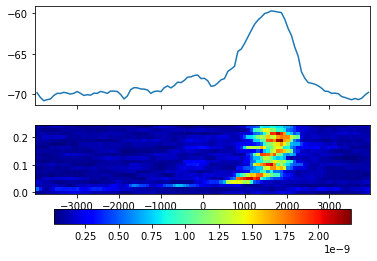

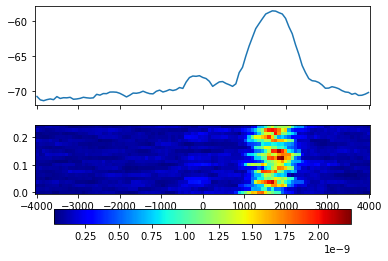

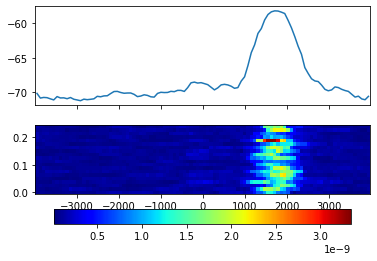

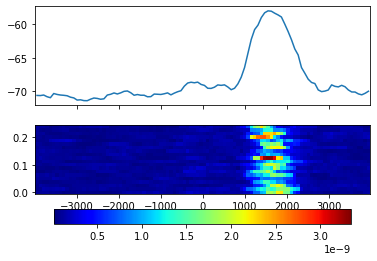

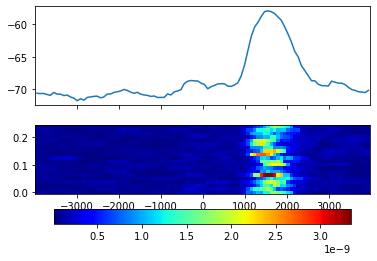

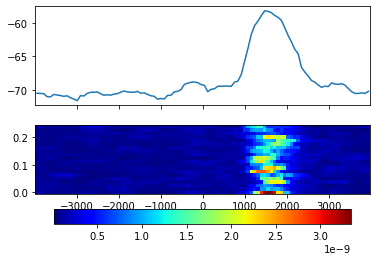

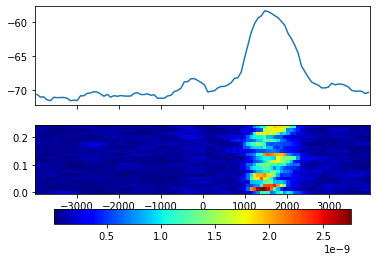

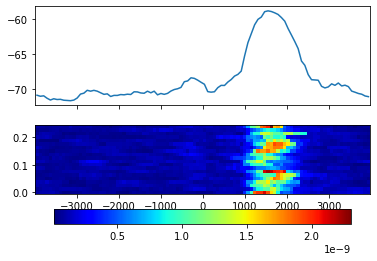

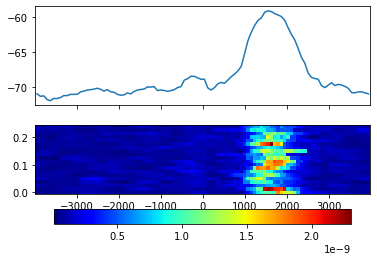

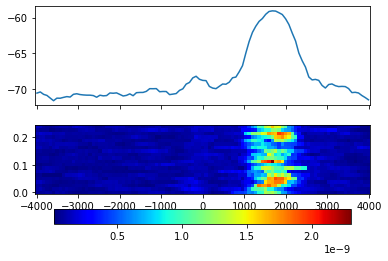

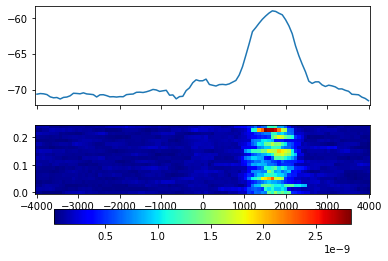

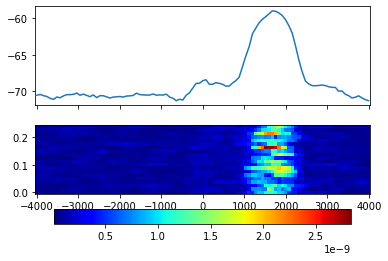

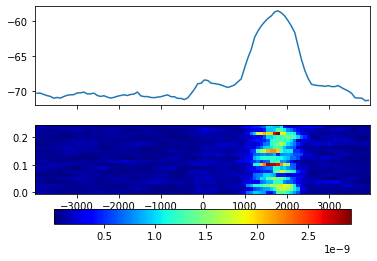

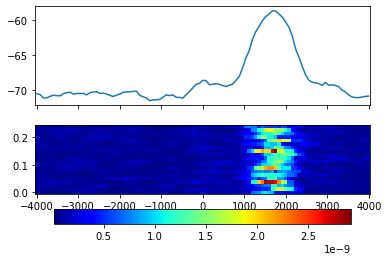

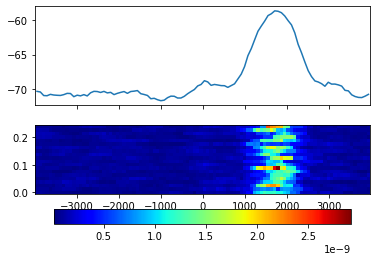

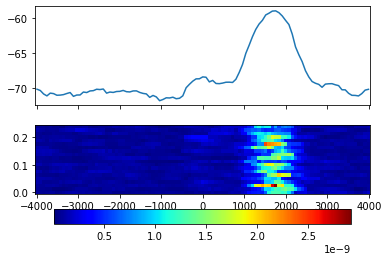

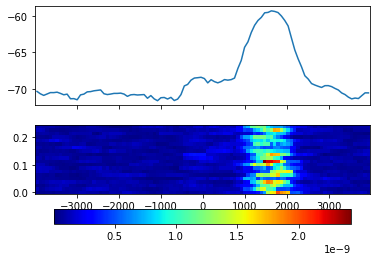

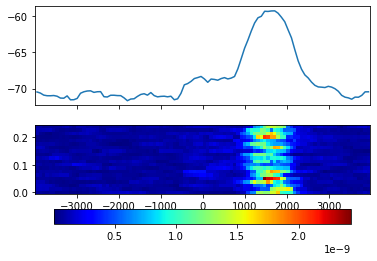

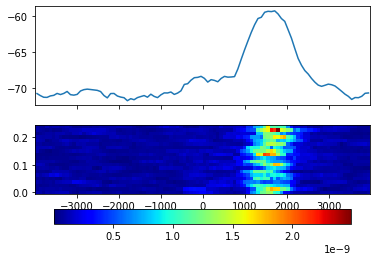

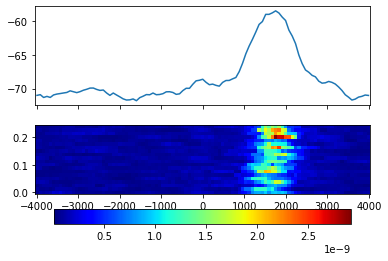

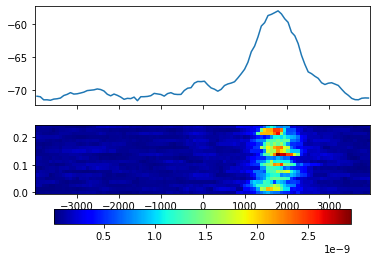

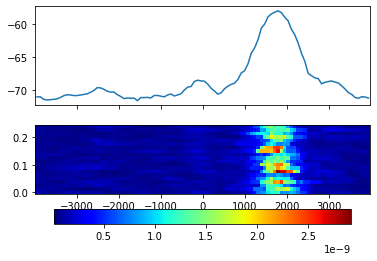

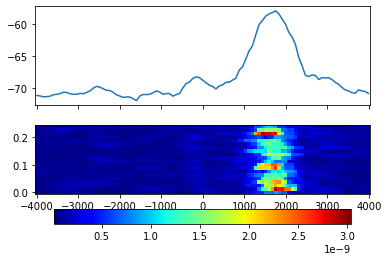

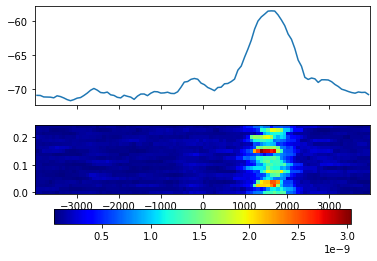

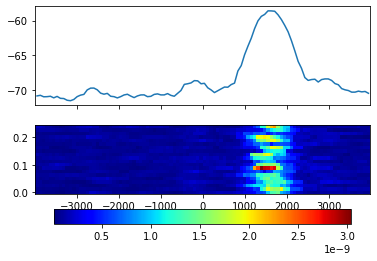

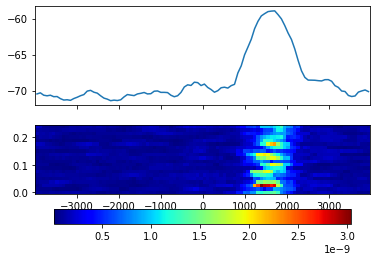

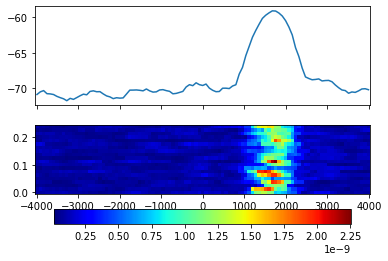

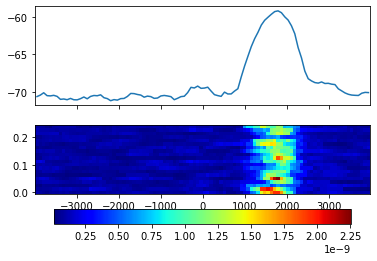

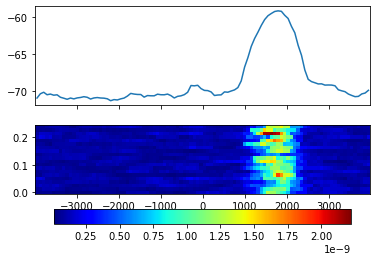

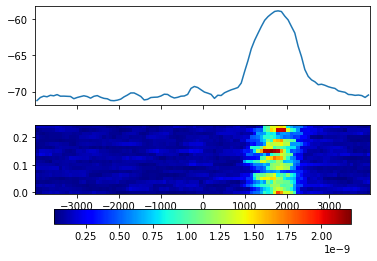

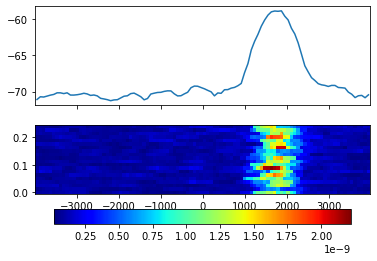

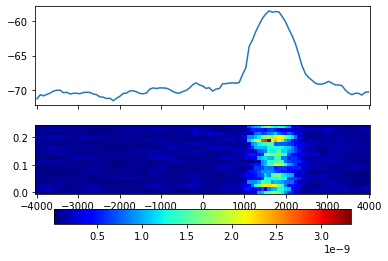

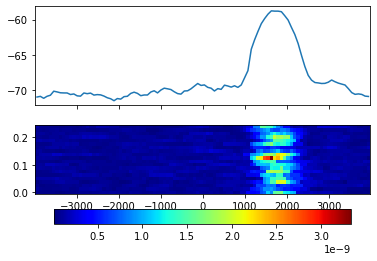

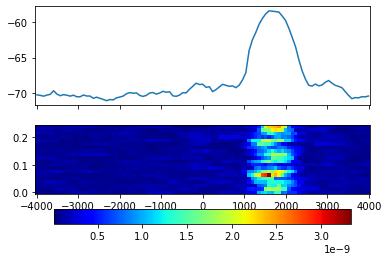

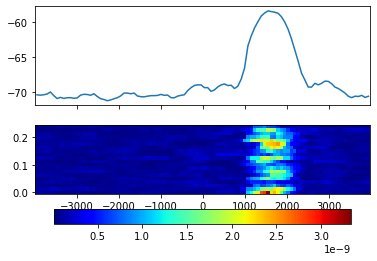

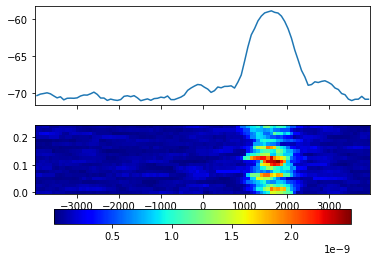

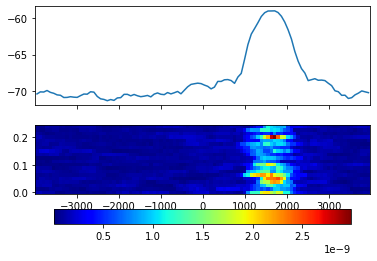

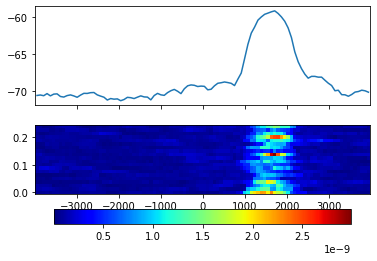

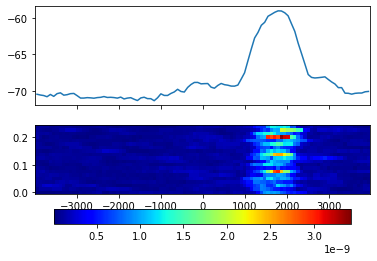

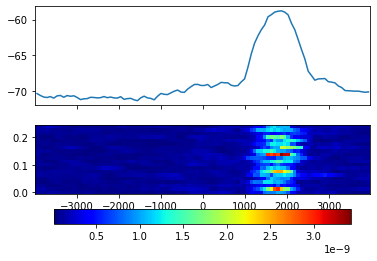

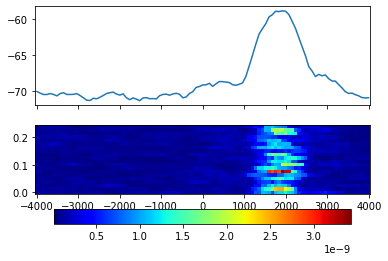

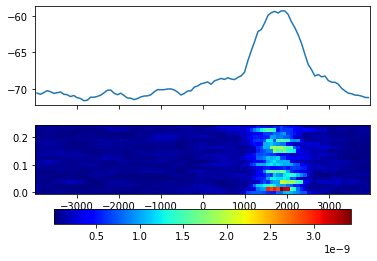

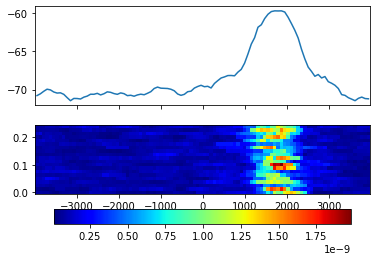

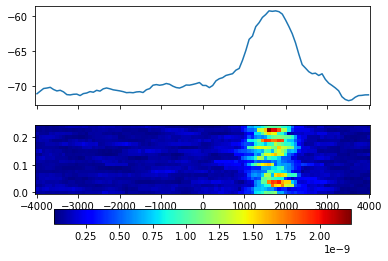

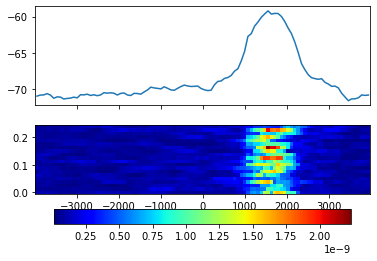

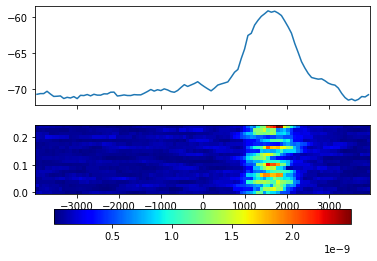

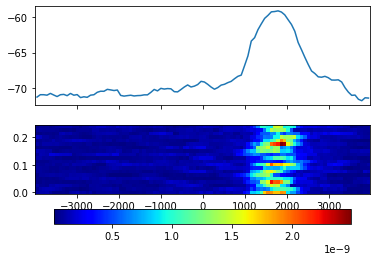

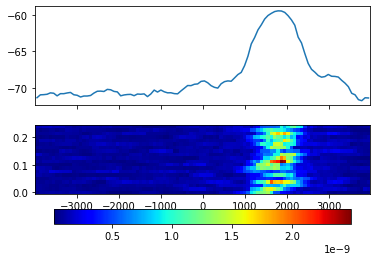

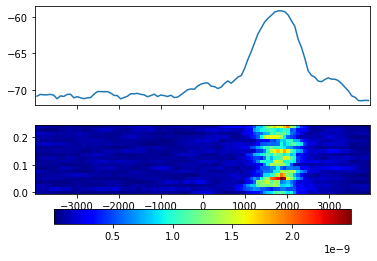

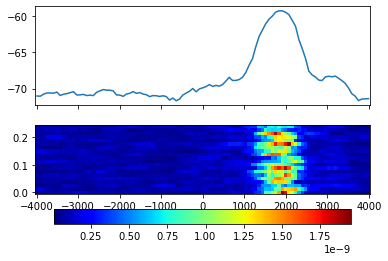

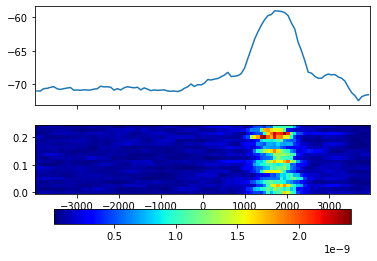

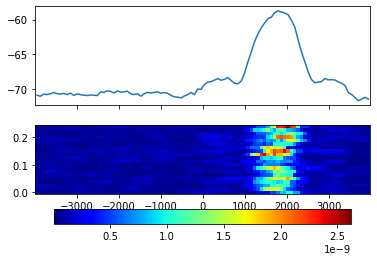

In [182]:
file='/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.08.21.18.07.820.tiq'
f2 = '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.23.54.31.735.tiq'
f3 = '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.55.25.448.tiq'
f4 = '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.58.49.912.tiq'
correct_spectrogram_shift_window(f3, time = 3.5, skip = 5.0 , step= 5, every = 20, xspan = 8e3, dbm = True)

# New plotting

In [8]:
import plotly.express as px
import pandas as pd

In [9]:
def plot_interactive_spectrogram(xx, yy, zz):
    frequency_kHz = [f'{x:0.3f}' for x in xx[0,:]/1000]
    time = [f'{y:0.3f}' for y in yy[:,0]]
    norm_power = zz / zz.max()
    
    panda_df = pd.DataFrame(data = norm_power, 
                            index = time, 
                            columns = frequency_kHz)

    fig = px.imshow(panda_df, color_continuous_scale = 'jet', origin = 'lower')
    fig.update_layout(
        #title = '2D Spectrum',
        #font_family="Avenir",
        #hoverlabel_font_family="Avenir",
        #coloraxis_showscale=False,
        xaxis = dict(
            showline = True,
            mirror = "ticks",
            linewidth = 2,
            ticks = "inside",
            title_text="Frequency (kHz)",
            title_font_size = 18,
            tickfont_size = 9,
            showgrid = True,
            nticks = 10,
        ),
        yaxis = dict(
            showline = True,
            mirror = "ticks",
            linewidth = 2,
            ticks = "inside",
            title_text = "Time (s)",
            title_font_size = 18,
            tickfont_size = 9,
            showgrid = False,
            nticks = 10
        ),
        coloraxis_colorbar = dict(
            orientation = 'h',
        ),
        height = 600,
        width = 900
        )
    return fig

In [10]:
def plot_interactive_spectrum(x, y):
    frequency_kHz = [f'{x:0.3f}' for x in x[0, :] / 1000]
    norm_power = [p/y.max() for p in y[0, :]]
    index = [f'{p/y.max()}' for p in y]
    print(len(frequency_kHz), len(norm_power), len(index))
    panda_df = pd.DataFrame(data = norm_power,
                            index = index,
                            columns = frequency_kHz)
    print(panda_df)
    #norm_power = IQBase.get_dbm(y)
    fig = px.line(panda_df, x = frequency_kHz, title = 'Spectrum')
    return fig

In [11]:
def plot_interactive_spectrum(x, y):
    frequency_kHz = [f'{x:0.3f}' for x in x/1000]
    norm_power = [p/y.max() for p in y]
    fig = px.line(x=frequency_kHz, y=norm_power, markers=True)
    fig.update_layout(
        xaxis = dict(
            showline = True,
            mirror = "ticks",
            linewidth = 2,
            ticks = "inside",
            title_text="Frequency (kHz)",
            title_font_size = 18,
            tickfont_size = 9,
            showgrid = True,
            nticks = 10,
        ),
        yaxis = dict(
            showline = True,
            mirror = "ticks",
            linewidth = 2,
            ticks = "inside",
            title_text = "PSD",
            title_font_size = 18,
            tickfont_size = 9,
            showgrid = False,
            nticks = 10
        )
    )
    return fig

In [121]:
file = '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.55.25.448.tiq'
xx, yy, zz = read_and_get_spectrogram(file, 512, 2, 5)
fig = plot_interactive_spectrogram(xx, yy, zz)
fig.show()

In [153]:
file = '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.55.25.448.tiq'
axx, azz = read_and_get_averaged_spectrogram(file, 512, 0.02, 5.145)
len(axx[0,:])
fig2 = plot_interactive_spectrum(axx[0,:], azz[0,:])
fig2.show()

# MOving window with new plotting

In [12]:
def correct_spectrogram_shift_window_new(filename, lframes = 612, time = 1, skip = 5.0, xcen = -2e3, xspan = 1e4, step = 1, every = 2, dbm = False):
    xx, yy, zz = read_and_get_spectrogram(filename, lframes, time, skip)
    i = 0
    while (i * step + every <= len(yy[:,0])):
        imin = i * step
        imax = i * step + every
        
        nxx = xx[imin:imax, :]
        nyy = yy[imin:imax, :]
        nzz = zz[imin:imax, :]
        
        axx, ayy, azz = get_averaged_spectrogram(nxx, nyy, nzz, every)
        xcen, sigma = fit_gaussian_peak(axx, azz)
        nxcen = abs(xcen) - 1900 #gs position - isomer position
        
        fxx, fyy, fzz = get_cut_spectrogram(nxx, nyy, nzz, xcen = nxcen, xspan = xspan)
        #plot_spectrogram(fxx, fyy, fzz)
        #plt.show()
        
        x, y, z = get_averaged_spectrogram(fxx, fyy, fzz, every)
        #plot_spectrum(x[0,:], z[0,:], dbm = True)
        #plt.show()
        plot_spectrum_spectrogram(fxx, fyy, fzz, x[0,:], z[0,:], cen = nxcen, span = xspan, dbm = dbm)
        i = i + 1
    

# track beam current

In [13]:
def read_masterfile(master_filename):
    # reads list filenames with experiment data. [:-1] to remove eol sequence.                        
    return [file[:-1] for file in open(master_filename).readlines()]

In [14]:
def track_current_gs(filename, lframes = 612, time = 9, skip = 0, nsigma = 3):
    axx, azz = read_and_get_averaged_spectrogram(filename, lframes, time, skip)
    xcen, sigma = fit_gaussian_peak(axx, azz)
    span = nsigma * 2  * sigma
    spanmask = (axx[0, :] <= xcen + span / 2) & (axx[0, :] >= xcen - span / 2)
    x = axx[0, spanmask]
    z = azz[0, spanmask]
    delta_x = abs(x[0] - x[1])
    return np.sum(z) * delta_x

In [26]:
def current_time(master_file):
    file_list = read_masterfile(master_file)
    area, years, months, days, hours, minutes, seconds = [list() for i in range(0,7)]
    for file in file_list:
        area.append(track_current_gs(file))
        time = get_tiq_time(file)
        year, month, day, hour, minute, second = strip_date(time)
        years.append(year)
        months.append(month)
        days.append(day)
        hours.append(hour)
        minutes.append(minute)
        seconds.append(second)
    data = np.stack((years, months, days, hours, minutes, seconds, area), axis = 1).reshape((len(area), 7))
    df = pd.DataFrame(data, columns=['year', 'month', 'day', 'hour', 'minute', 'second', 'area'])
    print(df)
    return df


In [37]:
def current_time2(master_file):
    file_list = read_masterfile(master_file)
    area, date = [list() for i in range(0,2)]
    for file in file_list:
        area.append(track_current_gs(file))
        date.append(get_tiq_time(file))
    data = np.stack((date, area), axis = 1).reshape((len(area), 2))
    df = pd.DataFrame(data, columns=['date', 'area'])
    print(df)
    return df


In [38]:
df2 = current_time2('/lustre/astrum/david/git/ashortiso/ashortiso/410_05.07.06.txt')

                                  date                    area
0    2021-05-07T05:54:28.4724732+02:00   4.336795136059017e-06
1    2021-05-07T05:54:40.5265506+02:00   4.741052299680091e-06
2    2021-05-07T05:54:52.5579669+02:00   4.837391797748525e-06
3    2021-05-07T05:55:04.5886050+02:00  1.0379844548546274e-06
4    2021-05-07T05:55:16.6163861+02:00  1.1193818985336657e-06
..                                 ...                     ...
294  2021-05-07T06:53:23.2772706+02:00   8.537948887097349e-07
295  2021-05-07T06:53:35.3050517+02:00  1.1186467499015038e-06
296  2021-05-07T06:53:47.3310716+02:00   1.047654600170281e-06
297  2021-05-07T06:53:59.3571016+02:00   8.357753959923801e-07
298  2021-05-07T06:54:11.3851388+02:00   4.859036728069393e-06

[299 rows x 2 columns]


In [51]:
df1 = df2.sort_values("date").reset_index(drop=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    299 non-null    object
 1   area    299 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [55]:
cols = df2.columns.drop('date')
df2[cols] = df2[cols].apply(pd.to_numeric)
fig2 = px.line(df2, x = 'date', y='area',markers=True)
fig.update_layout(autotypenumbers='convert types')
fig2.show()

In [57]:
df3 = current_time2('/lustre/astrum/david/git/ashortiso/ashortiso/iso.txt')
cols = df3.columns.drop('date')
df3[cols] = df3[cols].apply(pd.to_numeric)
fig3 = px.line(df3, x = 'date', y='area',markers=True)
fig3.show()

                                  date                    area
0    2021-05-08T21:12:03.7590165+02:00  1.1762816603347658e-05
1    2021-05-08T21:12:18.2993352+02:00  1.2304652808639185e-05
2    2021-05-08T21:12:32.8462229+02:00  1.1656237611746691e-05
3    2021-05-08T21:12:47.3890709+02:00    9.86229595624738e-06
4    2021-05-08T21:13:01.9333781+02:00  1.0972324717799054e-05
..                                 ...                     ...
669  2021-05-07T23:53:31.6212988+02:00   7.976593353367193e-07
670  2021-05-07T23:53:43.6561148+02:00    8.62259768635668e-07
671  2021-05-07T23:53:55.6926664+02:00   8.369400332014409e-07
672  2021-05-07T23:54:07.7314965+02:00  1.0160270115239195e-06
673  2021-05-07T23:54:20.8892770+02:00   9.326172779644466e-07

[674 rows x 2 columns]


In [27]:
df = current_time('/lustre/astrum/david/git/ashortiso/ashortiso/410_05.07.06.txt')

     year month day hour minute second                    area
0    2021    05  07   05     54     28   4.336795136059017e-06
1    2021    05  07   05     54     40   4.741052299680091e-06
2    2021    05  07   05     54     52   4.837391797748525e-06
3    2021    05  07   05     55     04  1.0379844548546274e-06
4    2021    05  07   05     55     16  1.1193818985336657e-06
..    ...   ...  ..  ...    ...    ...                     ...
294  2021    05  07   06     53     23   8.537948887097349e-07
295  2021    05  07   06     53     35  1.1186467499015038e-06
296  2021    05  07   06     53     47   1.047654600170281e-06
297  2021    05  07   06     53     59   8.357753959923801e-07
298  2021    05  07   06     54     11   4.859036728069393e-06

[299 rows x 7 columns]


In [32]:
fig = px.line(df, x = 'second', y='area', color='minute', markers=True)
fig.show()

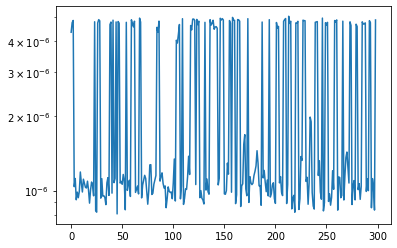

In [180]:
plt.plot(area)
plt.yscale('log')
plt.show()

In [182]:
fig = px.line(x = [i for i in range(len(area))],y=area, markers=True)
fig.show()

In [15]:
file = '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.55.25.448.tiq'
time = get_tiq_time(file)
time

'2021-05-07T06:49:46.7822383+02:00'

In [24]:
def strip_date(time):
    year = time[:4]
    month = time[5:7]
    day = time[8:10]
    hour = time[11:13]
    minute = time[14:16]
    second = time[17:19]
    return year, month, day, hour, minute, second

In [20]:
second

'46'